In [1]:
#import
import numpy as np
from scipy.optimize import fsolve
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, hstack, unique, vstack
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize, rosen, rosen_der

In [2]:
# Plotting properties
from matplotlib import rc
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['mathtext.default'] = 'regular'
labels_font = {'size':'20'} 

In [3]:
#initial conditions
M_solar = 2 #solar masses
X = 0.7
Y = 0.29
Z = 0.01
print(X+Y+Z)

1.0


In [4]:
#constants
k = 1.380658e-16
mu = 4/(3+5*X)
m_H = 1.6726231e-24
a = 7.5646e-15
c = 2.99792458e10
Ms = 1.989e33
Rs = 6.96e10
Ls = 3.826e33
M = M_solar * Ms
sb = 5.67051e-5
G = 6.67259e-8

# Opacity table

In [5]:
opacity_table = ((ascii.read('./opacity.txt', fast_reader=False)))
logR_tab = [-8.0,-7.5,-7.0,-6.5,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0]
logT_tab = opacity_table['col1'][:-9] 
del opacity_table['col1']
opacity_table=Table(opacity_table)
opacity_table = opacity_table[:-9]
del opacity_table['col18']
del opacity_table['col19']
del opacity_table['col20']
logR_tab = [-8.0,-7.5,-7.0,-6.5,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5]
opacity_table

col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.77,-0.931,-1.123,-1.331,-1.546,-1.76,-1.962,-2.135,-2.247,-2.266,-2.187,-2.034,-1.835,-1.617,-1.375,-1.096
-0.564,-0.602,-0.679,-0.799,-0.948,-1.114,-1.278,-1.414,-1.501,-1.511,-1.438,-1.309,-1.128,-0.939,-0.721,-0.487
-0.539,-0.535,-0.531,-0.53,-0.548,-0.593,-0.655,-0.712,-0.746,-0.734,-0.673,-0.565,-0.422,-0.264,-0.075,0.131
-0.541,-0.532,-0.515,-0.481,-0.416,-0.322,-0.219,-0.127,-0.05,0.019,0.092,0.182,0.295,0.415,0.566,0.736
-0.541,-0.534,-0.519,-0.484,-0.407,-0.268,-0.057,0.195,0.437,0.631,0.77,0.882,0.982,1.081,1.198,1.33
-0.521,-0.526,-0.52,-0.493,-0.423,-0.282,-0.05,0.27,0.635,0.98,1.248,1.435,1.57,1.678,1.78,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-0.478,-0.478,-0.478,-0.478,-0.478,-0.477,-0.473,-0.464,-0.44,-0.385,-0.28,-0.129,0.045,0.237,0.466,0.743
-0.48,-0.48,-0.48,-0.48,-0.48,-0.478,-0.474,-0.466,-0.448,-0.406,-0.328,-0.209,-0.052,0.144,0.378,0.652


In [6]:
logT_tab

3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
...
6.8


In [7]:
opacity = []
for i in opacity_table:
    temp=[]
    for j in i:
        temp.append(j)
    opacity.append(temp)
opacity=np.array(opacity)
np.shape(opacity),opacity

((61, 16),
 array([[-0.77 , -0.931, -1.123, -1.331, -1.546, -1.76 , -1.962, -2.135,
         -2.247, -2.266, -2.187, -2.034, -1.835, -1.617, -1.375, -1.096],
        [-0.564, -0.602, -0.679, -0.799, -0.948, -1.114, -1.278, -1.414,
         -1.501, -1.511, -1.438, -1.309, -1.128, -0.939, -0.721, -0.487],
        [-0.539, -0.535, -0.531, -0.53 , -0.548, -0.593, -0.655, -0.712,
         -0.746, -0.734, -0.673, -0.565, -0.422, -0.264, -0.075,  0.131],
        [-0.541, -0.532, -0.515, -0.481, -0.416, -0.322, -0.219, -0.127,
         -0.05 ,  0.019,  0.092,  0.182,  0.295,  0.415,  0.566,  0.736],
        [-0.541, -0.534, -0.519, -0.484, -0.407, -0.268, -0.057,  0.195,
          0.437,  0.631,  0.77 ,  0.882,  0.982,  1.081,  1.198,  1.33 ],
        [-0.521, -0.526, -0.52 , -0.493, -0.423, -0.282, -0.05 ,  0.27 ,
          0.635,  0.98 ,  1.248,  1.435,  1.57 ,  1.678,  1.78 ,  1.88 ],
        [-0.495, -0.494, -0.493, -0.479, -0.426, -0.3  , -0.074,  0.254,
          0.656,  1.086,  1.476,  

# Interpolate opacity table

In [8]:
def get_opacity(T,rho):
    """Return opacity from interpolated opacity table"""
    f = RectBivariateSpline(logT_tab, logR_tab, opacity)
    
    #R=density[g/cm**3]/T6**3, T6=1.e-6*T[degrees]
    logR = np.log10(rho/((T*1e-6)**3))
    log_op = f.ev(np.log10(T), logR)
    op = 10**log_op
    return op

# Energy generation rates

In [9]:
def get_e(rho, T):
    """Return energy generation from pp-chain and CNO cycle given density, temperature"""
    #pp chain from eqn 18.63 in Stellar Structure and Evolution (Second Edition)
    if T<1e7:
        psi = 1
    else:
        psi = 1.5

    Z_1 = 1
    Z_2 = 1
    zeta = 1
    T7 = T/(1e7)
    f_11 = np.exp(5.92*10**(-3)*Z_1*Z_2*(zeta*rho/(T7**3))**(1/2))
    T9 = T/(1e9)
    g_11 = (1+3.82*T9 + 1.51*T9**2 + 0.144*T9**3 - 0.0114*T9**4)
    e_pp = 2.57*10**4*psi*f_11*g_11*rho*X**2*T9**(-2/3)*np.exp(-3.381/(T9**(1/3)))

    #CNO from eqn 18.65 in Stellar Structure and Evolution (Second Edition)
    X_cno = 0.7*Z 
    g_14_1 = 1 - 2.00*T9 + 3.41*T9**2 - 2.43*T9**3
    e_cno = 8.24*10**25*g_14_1*X_cno*X*rho*T9**(-2/3)*np.exp(-15.231*T9**(-1/3) - (T9/0.8)**2)
    
    return e_cno + e_pp

# E.O.S.

In [11]:
#calculate density given pressure P, temperature, and composition (i.e., the equation of state) assuming complete 
#ionization (include the effect of radiation pressure)

def get_rho(P,T):
    """Calculate density given pressure and temperature (with fixed composition). Using an equation of state 
    that includes ideal gas pressure and radiation pressure (assuming complete ionization)."""
    rho = (P - (1/3)*a*T**4)*(mu*m_H)/(k*T)
    return rho

# Shoot for a solution

In [12]:
def get_del(P,l,T,m):
    """Return value of del by determine del_ad and del_rad and comparing their values."""
    del_rad = 3*P*get_opacity(T,get_rho(P,T))*l/(16*np.pi*a*c*T**4*G*m)
    del_ad = 0.4 #(Gamma_2 - 1)/Gamma_2
    if del_rad <= del_ad:
        del_final = del_rad
    else:
        del_final = del_ad
    return del_final

def derivs(m, ics):
    """Return derivatives of l,P,r,T with dependent variable m (four equations of stellar structure)."""
    l, P, r, T = ics
    dl_dm = get_e(get_rho(P,T), T)
    dP_dm = -G*m/(4*np.pi*r**4)
    dr_dm = 1/(4*np.pi*r**2*get_rho(P,T))
    dT_dm = -G*m*T*get_del(P,l,T,m)/(4*np.pi*r**4*P)
    return dl_dm, dP_dm, dr_dm, dT_dm

In [13]:
def load1(T_c,P_c,L_star,R_star):
    """Give boundary conditions at center (a point just outside the star's center)"""
    r = (3/(4*np.pi*get_rho(P_c,T_c)))**(1/3)*dm**(1/3)
    l = get_e(get_rho(P_c,T_c), T_c)*dm 
    P = P_c - (3*G/(8*np.pi))*(4*np.pi*get_rho(P_c,T_c)/3)**(4/3)*dm**(2/3)
    if 3*P*get_opacity(T_c,get_rho(P,T_c))*l/(16*np.pi*a*c*T_c**4*G*dm)>0.4:
        T = np.exp(np.log(T_c) - (np.pi/6)**(1/3)*G*(0.4*get_rho(P_c,T_c)**(4/3)/P_c)*dm**(2/3))
    else:
        rho_c = get_rho(P_c,T_c)
        e_c = get_e(rho_c,T_c)
        T = (T_c**4 - (1/(2*a*c)) *(3/(4*np.pi))**(2/3) *get_opacity(T_c, rho_c) *e_c*rho_c**(4/3)*dm**(2/3))**(1/4)
    return l,P,r,T
    

def load2(T_c,P_c,L_star,R_star):
    """Give boundary conditions at surface"""
    T = (L_star/(4*np.pi*R_star**2*sb))**(1/4)
    rho = get_rho(P_c,T)
    P = 2*G*M/(3*R_star**2*get_opacity(T, rho))
    return L_star,P,R_star,T


# Solve derivatives

In [15]:
def fun(ic_scales, x):
    """Returns expression to minimize differences between l,P,r,T at M/s"""
    T_c,P_c,L_star,R_star = x*ic_scales
    l_cent, P_cent, r_cent, T_cent = load1(T_c,P_c,L_star,R_star)
    l_surf, P_surf, r_surf, T_surf = load2(T_c,P_c,L_star,R_star)
    result = solve_ivp(derivs,[dm,M/2],[l_cent, P_cent, r_cent, T_cent])
    l = result.y[0][-1]
    P = result.y[1][-1]
    r = result.y[2][-1]
    T = result.y[3][-1]
    result2 = solve_ivp(derivs,[M,M/2],[l_surf, P_surf, r_surf, T_surf])
    l2 = result2.y[0][-1]
    P2 = result2.y[1][-1]
    r2 = result2.y[2][-1]
    T2 = result2.y[3][-1]
    scale = (result2.y[:, 0] - result.y[:, 0])
    return ((l-l2)/scale[0])**2 + ((P-P2)/scale[1])**2 + ((r-r2)/scale[2])**2 + ((T-T2)/scale[3])**2

In [16]:
#Set initial guesses
L_star = (M_solar)**3.5*Ls
R_star = (M_solar)**0.75*Rs
T_c = M_solar**0.22*1.6e7
P_c = ((1/3)*a*T_c**4 + 162*M_solar**(-1.33)*k*T_c/(mu*m_H))

#Set value for mass slightly away from center
dm=1e-5

#Minimize function
ic_scales=[1,1,1,1]
bound_arr = np.array([[0.3]*4, [2]*4]).T
res = minimize(fun, x0=ic_scales, args=[T_c,P_c,L_star,R_star], bounds=bound_arr, method='L-BFGS-B')
res.x  


array([1.08265404, 1.24350772, 1.07494021, 0.83772407])

In [17]:
#Check values, convergence, and number of iterations
res, T_c,P_c,L_star,R_star

(      fun: 0.0005372501530595085
  hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 1.27471738e+02, -1.01876007e-03, -4.02478682e-04, -2.97610622e-04])
   message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 480
       nit: 31
      njev: 96
    status: 0
   success: True
         x: array([1.08265404, 1.24350772, 1.07494021, 0.83772407]),
 18635737.383495294,
 1.6138096038493126e+17,
 4.32862487171157e+34,
 117052781003.31706)

In [18]:
print('Initial guesses: ', T_c,P_c,L_star,R_star)
T_c,P_c,L_star,R_star = [T_c,P_c,L_star,R_star]*res.x
print('Best fits: ', T_c,P_c,L_star,R_star)

#get values for best fit
l_cent, P_cent, r_cent, T_cent = load1(T_c,P_c,L_star,R_star)
l_surf, P_surf, r_surf, T_surf = load2(T_c,P_c,L_star,R_star)
result = solve_ivp(derivs,[dm,M/2],[l_cent, P_cent, r_cent, T_cent])
l = result.y[0][-1]
P = result.y[1][-1]
r = result.y[2][-1]
T = result.y[3][-1]
result2 = solve_ivp(derivs,[M,M/2],[l_surf, P_surf, r_surf, T_surf])
l2 = result2.y[0][-1]
P2 = result2.y[1][-1]
r2 = result2.y[2][-1]
T2 = result2.y[3][-1]

18635737.383495294 1.6138096038493126e+17 4.32862487171157e+34 117052781003.31706
20176056.33442483 2.006784694770129e+17 4.653012917744822e+34 98057931957.24261


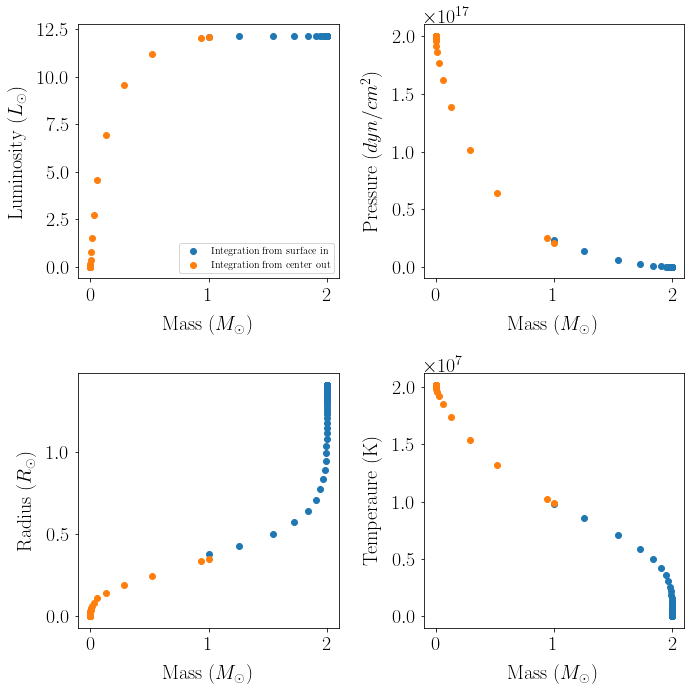

In [30]:
#Plot L,P,R,T as function of mass for best fit solution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.scatter(result2.t/Ms,result2.y[0]/Ls, label='Integration from surface in')
ax1.scatter(result.t/Ms,result.y[0]/Ls, label='Integration from center out')
ax1.set_ylabel(r'Luminosity ($L_\odot$)')
ax1.set_xlabel(r'Mass ($M_\odot$)')
ax1.legend() 

ax2.scatter(result2.t/Ms,result2.y[1])
ax2.scatter(result.t/Ms,result.y[1])
ax2.set_ylabel(r'Pressure ($dyn/cm^2$)')
ax2.set_xlabel(r'Mass ($M_\odot$)')

ax3.scatter(result2.t/Ms,result2.y[2]/Rs)
ax3.scatter(result.t/Ms,result.y[2]/Rs)
ax3.set_ylabel(r'Radius ($R_\odot$)')
ax3.set_xlabel(r'Mass ($M_\odot$)')

ax4.scatter(result2.t/Ms,result2.y[3])
ax4.scatter(result.t/Ms,result.y[3])
ax4.set_ylabel('Temperaure (K)')
ax4.set_xlabel(r'Mass ($M_\odot$)')

fig.tight_layout()

plt.savefig('./figs/converged_soln.png',bbox_inches='tight')
plt.show()

In [36]:
#Construct table with values

e_final = np.zeros_like(result.t)
opacity_final = np.zeros_like(result.t)
del_final = np.zeros_like(result.t)
del_ad_final = np.full(len(result.t), 0.4) 

for i,P,T,L,M in zip(range(len(e_final)), result.y[1], result.y[3],result.y[0], result.t):
    rho = get_rho(P,T)
    e_final[i] = get_e(rho,T)
    opacity_final[i] = get_opacity(T,rho)
    del_final[i] = 3*P*get_opacity(T,rho)*L/(16*np.pi*a*c*T**4*G*M)

shell = np.full(len(result.t), 'Convective')
shell[del_final<=del_ad_final] = 'Radiative'

tab1 = Table([result.t/Ms, result.y[2]/Rs, get_rho(result.y[1], result.y[3]), result.y[3], result.y[1], 
              result.y[0]/Ls, e_final, opacity_final, del_ad_final, del_final, shell],
      names=[r'Mass ($M_\odot$)', 'Radius ($R_\odot$)', r'Density ($g/cm^3$)', 'Temperature (K)', 
             r'Pressure ($dyn/cm^2$)', r'Luminosity ($L_\odot$)', r'Nuclear energy generation rate $\epsilon$', 
             'Opacity', r'$\nabla_{ad}$', r'$\nabla$', 'Radiative/Convective'])

e_final2 = np.zeros_like(result2.t)
opacity_final2 = np.zeros_like(result2.t)
del_final2 = np.zeros_like(result2.t)
del_ad_final2 = np.full(len(result2.t), 0.4) 

for i,P,T,L,M in zip(range(len(e_final2)), result2.y[1], result2.y[3],result2.y[0], result2.t):
    rho = get_rho(P,T)
    e_final2[i] = get_e(rho,T)
    opacity_final2[i] = get_opacity(T,rho)
    del_final2[i] = 3*P*get_opacity(T,rho)*L/(16*np.pi*a*c*T**4*G*M)

shell2 = np.full(len(result2.t), 'Convective')
shell2[del_final2<=del_ad_final2] = 'Radiative'

tab2 = Table([result2.t/Ms, result2.y[2]/Rs, get_rho(result2.y[1], result2.y[3]), result2.y[3], result2.y[1], 
              result2.y[0]/Ls, e_final2, opacity_final2, del_ad_final2, del_final2, shell2],
      names=[r'Mass ($M_\odot$)', 'Radius ($R_\odot$)', r'Density ($g/cm^3$)', 'Temperature (K)', 
             r'Pressure ($dyn/cm^2$)', r'Luminosity ($L_\odot$)', r'Nuclear energy generation rate $\epsilon$', 
             'Opacity', r'$\nabla_{ad}$', r'$\nabla$', 'Radiative/Convective'])
tab2.reverse()
final_table = vstack([tab1,tab2])

In [37]:
final_table[::15]

Mass ($M_\odot$),Radius ($R_\odot$),Density ($g/cm^3$),Temperature (K),Pressure ($dyn/cm^2$),Luminosity ($L_\odot$),Nuclear energy generation rate $\epsilon$,Opacity,$\nabla_{ad}$,$\nabla$,Radiative/Convective
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10
5.027652086475616e-39,4.573920252998607e-14,73.99764643905195,20176056.334424842,2.006784694770129e+17,7.281774769712973e-37,278.60070268922095,0.6324288790611587,0.4,0.8415885946364497,Convective
1.796178714434232e-32,6.8451465940033435e-12,73.99764643905195,20176056.334424842,2.006784694770129e+17,2.6014864632034304e-30,278.60070268922095,0.6324288790611587,0.4,0.8415885946364577,Convective
2.955263046707119e-26,8.208843809651737e-10,73.99764643905195,20176056.334424842,2.006784694770129e+17,4.280240462394924e-24,278.60070268922095,0.6324288790611587,0.4,0.8415885946364576,Convective
1.1121682019717442e-19,1.2702500363006818e-07,73.99764643903896,20176056.334422465,2.0067846947695395e+17,1.6108032563691836e-17,278.60070268872516,0.6324288790612214,0.4,0.8415885946357838,Convective
2.376895903599247e-13,1.6271793312363247e-05,73.9976462265131,20176056.295710433,2.0067846851434368e+17,3.4425652418485227e-11,278.60069460828015,0.6324288800747443,0.4,0.8415885838176193,Convective
9.735936665164184e-07,0.0025752545600275607,73.99253252225796,20175124.805195484,2.0065530706607827e+17,0.00014094548110755743,278.4063375960626,0.6324532686350832,0.4,0.8412945178437862,Convective
0.28853102271117814,0.19102143050714032,48.99086127467049,15376261.713816203,1.0118418200959117e+17,9.567993355284624,20.94152022365477,0.7984955786331673,0.4,0.36363938256235356,Radiative
1.996614620659809,1.0379266010075932,0.019958744733575968,1570857.6097607168,4220793579420.3164,12.161560161380457,4.43165518900852e-09,7.173724165010455,0.4,0.22979841127902265,Radiative
1.9999995296319164,1.3582112996335318,9.171648134061788e-06,192357.5245637759,240097581.54026797,12.16156016138218,1.2777150270493805e-24,30.840556439583647,0.4,0.24951297931244223,Radiative


In [24]:
tab2

Mass ($M_\odot$),Radius ($R_\odot$),Density ($g/cm^3$),Temperature (K),Pressure ($dyn/cm^2$),Luminosity ($L_\odot$),Nuclear energy generation rate $\epsilon$,Opacity,$\nabla_{ad}$,$\nabla$,Radiative/Convective
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10
1.0,0.3774709854967008,17.74142410433606,9820976.847286463,2.3394848184734296e+16,12.079325208083413,0.7215015465530459,1.1377791356500175,0.4,0.26221805526019365,Radiative
1.255337065991304,0.42838606120108463,11.74190186542967,8571492.29187374,1.3513688895292838e+16,12.139682923390833,0.25012511270457743,1.2859786321038895,0.4,0.23620515681995616,Radiative
1.5428010646521662,0.5023044664503314,5.933923369116964,7049877.676649775,5617546897113341.0,12.158957561922712,0.04703277287913853,1.5656243629035187,0.4,0.212889790427795,Radiative
1.7256560218882264,0.5727604155319322,2.940940692402757,5882920.9073089175,2323729090929754.0,12.161264443814257,0.00873183330293844,1.9292355055397414,0.4,0.20011685731492146,Radiative
1.8383688626133303,0.641578487062524,1.451838930560308,4954541.5131962495,966377191282804.5,12.161527992968134,0.0015944488416461797,2.4136260089231167,0.4,0.1942758063488773,Radiative
1.905868159656005,0.7086948963532763,0.7252018212014736,4199501.221229954,409289825676292.4,12.161556772887394,0.00028769206192108706,3.038701539265938,0.4,0.19359089803677337,Radiative
...,...,...,...,...,...,...,...,...,...,...
1.9999999999834266,1.4069358830779681,4.0376010366834655e-09,15006.866008788227,8255.345685813892,12.16156016138218,2.484934707202939e-61,28.63480412477694,0.4,0.21502513453149055,Radiative
1.999999999989797,1.4073761180554376,2.8751602327965775e-09,13636.577026464802,5346.262223660613,12.16156016138218,2.2122090144392785e-63,31.934210984352404,0.4,0.22777430698040646,Radiative


In [27]:
final_table.write('final_table3.fits') #save final table

In [82]:
latex_tab = vstack([final_table[:int(len(final_table)/3)+30:40],
                    final_table[int(len(final_table)/3)+30:int(2*len(final_table)/3):3],
                    final_table[int(2*len(final_table)/3)::20]])

In [83]:
latex_tab.round(4)
latex_tab

Mass ($M_\odot$),Radius ($R_\odot$),Density ($g/cm^3$),Temperature (K),Pressure ($dyn/cm^2$),Luminosity ($L_\odot$),Nuclear energy generation rate $\epsilon$,Opacity,$\nabla_{ad}$,$\nabla$,Radiative/Convective
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10
0.0,0.0,74.0,20176056.33,2.006784694770129e+17,0.0,278.6,0.63,0.4,0.84,Convective
0.0,0.0,73.9976,20176056.3344,2.006784694770111e+17,0.0,278.6007,0.6324,0.4,0.8416,Convective
0.0,0.0059,73.9695,20170931.9878,2.0055107283384934e+17,0.0016,277.5334,0.6326,0.4,0.8402,Convective
0.0002,0.0163,73.7837,20137060.8909,1.9971027301254794e+17,0.0326,270.591,0.6335,0.4,0.8306,Convective
0.0027,0.0372,72.8723,19970540.7402,1.956074112293791e+17,0.3567,239.1528,0.6379,0.4,0.787,Convective
0.0285,0.0828,68.5821,19177094.1536,1.7675576579345395e+17,2.7278,136.721,0.6599,0.4,0.6253,Convective
0.29,0.19,48.99,15376261.71,1.0118418200959117e+17,9.57,20.94,0.8,0.4,0.36,Radiative
1.0,0.3494,15.8934,9864206.7792,2.105292790438819e+16,12.0756,0.6586,1.0805,0.4,0.2201,Radiative
1.5428,0.5023,5.9339,7049877.6766,5617546897113341.0,12.159,0.047,1.5656,0.4,0.2129,Radiative


In [85]:
latex_tab.write('latex_tab.csv')